In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scipy.signal
from scipy.fft import fft
import scipy.stats
from scipy.interpolate import interp1d

In [3]:
import nidaqmx

# Calibrate

In [13]:
with nidaqmx.Task() as aitask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(100.0)
      
    # read 10 samples
    data = aitask.read(10, timeout=1)

print("Voltage: {}+-{}".format(np.mean(data), np.std(data)))

Voltage: 2.2768860206587993+-0.0003451596145276411


# Run tests

Generate a sample waveform. We have ao0 producing an output, which is sent to the Arduino, which modifies it in some way, and then the modified version is read on ai0

## Loop rate

The Arduino is supposed to output a HIGH signal during the processing loop function, so we can verify that the loop is happening as often as it should, and check how long it takes the processing function to run.

In [94]:
hisampfreq = 400e3    # Hz
outfreq = 500.0     # Hz

dur = 10.0    # sec
amp = 1 # V

freq1 = 0.5
freq2 = 2

t = np.arange(0, dur, step=1.0/hisampfreq)
tout = np.arange(0, dur, step=1.0/outfreq)
inwave = 0.4 * scipy.signal.chirp(tout, f0=freq1, f1=freq2, t1=dur, 
                                  method='logarithmic') + 1

freq = freq1 * (freq2/freq1)**(t/dur)

ninsamp = int(len(inwave) * hisampfreq / outfreq)

In [95]:
print("MOOCH!")

MOOCH!


In [124]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    # aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai1')
    aitask.timing.cfg_samp_clk_timing(hisampfreq, samps_per_chan=ninsamp)
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(outfreq, samps_per_chan=len(inwave))
    aotask.write(inwave, auto_start=True)
    
    aitask.start()
    
    outwave = aitask.read(ninsamp, timeout=dur+1)

outwave = np.array(outwave)

In [125]:
timingpulse = outwave # outwave[1,:]
isup = np.insert((timingpulse[1:] >= 1.0) & (timingpulse[:-1] < 1.0),
                 0, False)
isdown = np.append((timingpulse[1:] < 1.0) & (timingpulse[:-1] >= 1.0),
                 False)

tup = t[isup]
tdown = t[isdown]

if tdown[0] < tup[0]:
    tdown = tdown[1:]
if tup[-1] > tdown[-1]:
    tup = tup[:-1]

pulseper = np.diff(tup) * 1e6
pulseper = np.append(pulsefreq, np.nan)
pulsedur = (tdown - tup) * 1e6

(1, 1.1)

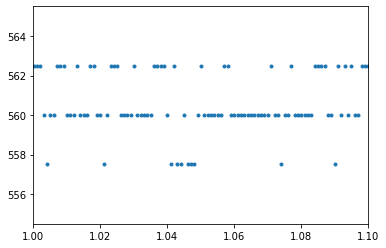

In [126]:
plt.plot(tup, pulsedur, '.')
plt.xlim([1, 1.1])

In [127]:
print('Pulse period: {}+-{}us'.format(np.nanmean(pulseper), np.nanstd(pulseper)))
print('Pulse dur: {}+-{}us'.format(np.nanmean(pulsedur), np.nanstd(pulsedur)))

Pulse period: 1000.5939423960642+-1.0675229470788574us
Pulse dur: 560.6653004098715+-1.5693163323858248us


## Frequency sweep

Sweep frequencies from a low frequency to a high(ish) one.

In [19]:
sampfreq = 100.0    # Hz
dur = 30.0    # sec
amp = 1 # V

freq1 = 0.5
freq2 = 15

t = np.arange(0, dur, step=1.0/sampfreq)
inwave = 0.4 * scipy.signal.chirp(t, f0=freq1, f1=freq2, t1=dur, 
                                  method='logarithmic') + 1.5

freq = freq1 * (freq2/freq1)**(t/dur)

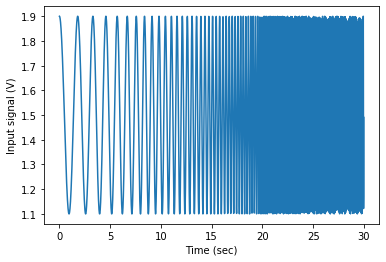

In [20]:
fig, ax = plt.subplots()

ax.plot(t, inwave)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Input signal (V)')
plt.show()

Output the test signal and read the output from the microcontroller. Here we use `inwave` to refer to the microcontroller input and `outwave` to refer to the microcontroller output.

In [24]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(sampfreq, samps_per_chan=len(inwave))
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock",
                                     samps_per_chan=len(inwave))
    aotask.write(inwave, auto_start=True)
    
    aitask.start()
    outwave = aitask.read(len(inwave), timeout=dur+1)

outwave = np.array(outwave)

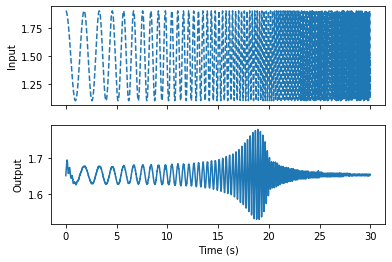

In [25]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(t, inwave, '--', label='input')
ax[1].plot(t, outwave, label='output')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Input')
ax[1].set_ylabel('Output')

# ax[1].set_ylim([0, 0.1])
plt.show()

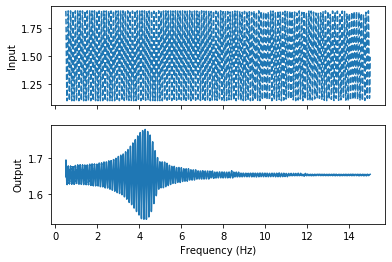

In [26]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(freq, inwave, '--', label='input')
ax[1].plot(freq, outwave, label='output')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Input')
ax[1].set_ylabel('Output')

plt.show()

In [27]:
good = t > 1.0

outH = scipy.signal.hilbert(outwave[good] - np.mean(outwave[good]))
inH = scipy.signal.hilbert(inwave[good] - np.mean(inwave[good]))

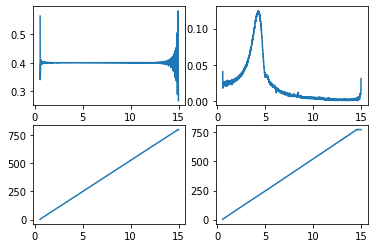

In [28]:
freq1 = freq[good]

fig, ax = plt.subplots(2,2)
ax[0,0].plot(freq1, np.abs(inH))
ax[1,0].plot(freq1, np.unwrap(np.angle(inH)))

ax[0,1].plot(freq1, np.abs(outH))
ax[1,1].plot(freq1, np.unwrap(np.angle(outH)))

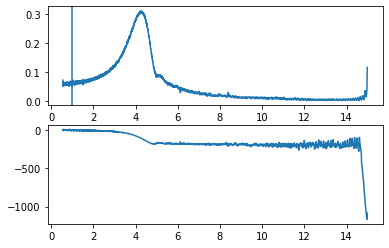

In [29]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(freq1, np.abs(outH) / np.abs(inH))
ax[0].axvline(1.0)

ax[1].plot(freq1, np.rad2deg(np.unwrap(np.angle(outH) - np.angle(inH))))

#ax[1].set_ylim([-180, 0])
#ax[1].axhline(-90)
#ax[1].axvline(1.0)

# Sum of sines

In [36]:
sampfreq = 100.0     # Hz
dur = 60.0    # sec

freq1 = 0.1
freq2 = 30
nfreqs = 17

logfreq = np.linspace(np.log(freq1), np.log(freq2), nfreqs)
freqs = np.exp(logfreq)
phases = scipy.stats.uniform.rvs(size=(nfreqs,))

t = np.arange(0, dur, step=1.0/sampfreq)

inwave = np.zeros_like(t)
for f1, p1 in zip(freqs, phases):
    inwave += np.sin(2*np.pi*(f1 * t + p1))

inwave /= np.ptp(inwave) / 2
inwave *= 0.8
inwave += 1

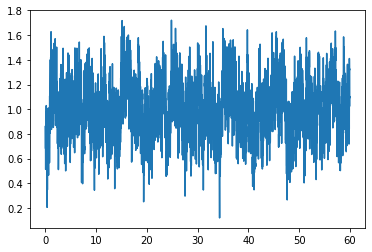

In [37]:
plt.plot(t, inwave)

In [38]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(sampfreq, samps_per_chan=len(inwave))
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock",
                                     samps_per_chan=len(inwave))
    aotask.write(inwave, auto_start=True)
    
    aitask.start()
    outwave = aitask.read(len(inwave), timeout=dur+1)

outwave = np.array(outwave)

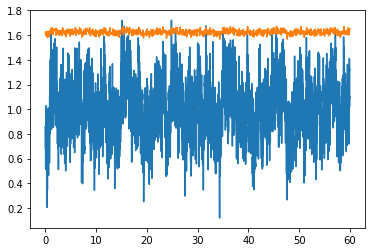

In [39]:
plt.plot(t, inwave)
plt.plot(t, outwave)

In [40]:
good = t > 0

f, Pin = scipy.signal.welch(inwave[good], fs=sampfreq, nperseg=1024)
f, Pout = scipy.signal.welch(outwave[good], fs=sampfreq, nperseg=1024)

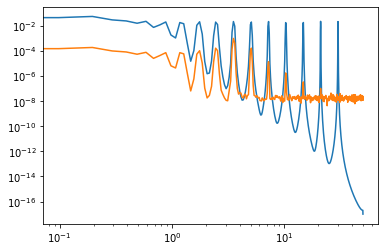

In [41]:
plt.loglog(f, Pin)
plt.loglog(f, Pout)
# plt.xlim([0, 5])

In [42]:
I = fft(inwave)
O = fft(outwave)

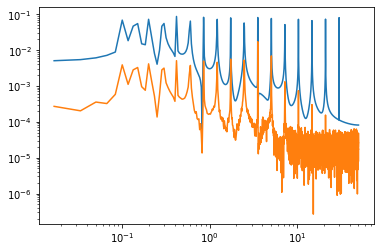

In [43]:
N = len(outwave)
f = np.linspace(0, sampfreq, N)

plt.loglog(f[1:N//2], 2.0/N * np.abs(I[1:N//2]))
plt.loglog(f[1:N//2], 2.0/N * np.abs(O[1:N//2]))

In [44]:
If = interp1d(f[1:N//2], 2.0/N * I[1:N//2], kind='nearest')
Of = interp1d(f[1:N//2], 2.0/N * O[1:N//2], kind='nearest')

In [45]:
H = Of(freqs) / If(freqs)

In [46]:
zeta = 0.1
omegar = 2*np.pi * 4.0
omegas = 2*np.pi * freqs

Htrue = 1.0 / (-omegas**2 - 2*(1j)*zeta*omegar*omegas + omegar**2)

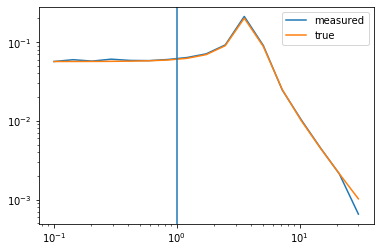

In [47]:
fig, ax = plt.subplots()
ax.loglog(freqs, np.abs(H), label='measured')
ax.loglog(freqs, np.abs(Htrue)/np.abs(Htrue[0])*np.abs(H[0]), label='true')
ax.axvline(1)
ax.legend()
plt.show()

## White noise

In [154]:
sampfreq = 100.0     # Hz
dur = 60.0    # sec

# bandwidth
freq1 = 0.1
freq2 = 30

t = np.arange(0, dur, step=1.0/sampfreq)

noise = scipy.stats.norm.rvs(size=len(t))

sos = scipy.signal.butter(9, [freq1, freq2], fs=sampfreq,
                          btype='bandpass', output='sos')
inwave = scipy.signal.sosfiltfilt(sos, noise)
inwave = np.array(inwave)

In [155]:
f, Pnoise = scipy.signal.welch(noise, sampfreq, nperseg=4096)
f, Pin = scipy.signal.welch(inwave, sampfreq, nperseg=4096)

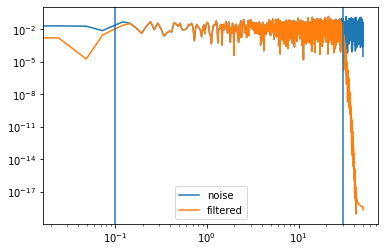

In [158]:
plt.loglog(f, Pnoise, label='noise')
plt.loglog(f, Pin, label='filtered')
plt.axvline(freq1)
plt.axvline(freq2)

plt.legend(loc='best')

In [159]:
with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
    aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
    aitask.timing.cfg_samp_clk_timing(sampfreq, samps_per_chan=len(inwave))
    
    aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')
    
    aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock",
                                     samps_per_chan=len(inwave))
    aotask.write(inwave, auto_start=True)
    
    aitask.start()
    outwave = aitask.read(len(inwave), timeout=dur+1)

outwave = np.array(outwave)

In [160]:
nperseg = 512

f, Pxy = scipy.signal.csd(inwave, outwave, fs=sampfreq, 
                          nperseg=nperseg, noverlap=2*nperseg//4, 
                          scaling='spectrum')
f, Pxx = scipy.signal.welch(inwave, fs=sampfreq, 
                            nperseg=nperseg, noverlap=2*nperseg//4,
                            scaling='spectrum')

H = Pxy / Pxx

In [161]:
zeta = 0.2
omegar = 2*np.pi
omegas = 2*np.pi * f

Htrue = 1.0 / (-omegas**2 - 2*(1j)*zeta*omegar*omegas + omegar**2)

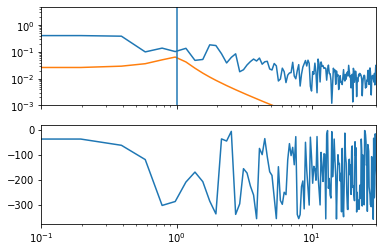

In [163]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].loglog(f, np.abs(H))
ax[0].loglog(f, np.abs(Htrue))
ax[1].semilogx(f, np.rad2deg(np.angle(H) - np.angle(H[0])))

ax[0].set_ylim([1e-3, 5])
ax[0].set_xlim([freq1, freq2])

ax[0].axvline(1)

# Check system with different parameters

In [51]:
def get_transfer_function(dur, freqs, nfreqs, sampfreq=100.0, amplitude=0.3):
    logfreq = np.linspace(np.log(freqs[0]), np.log(freqs[1]), nfreqs)
    freqs = np.exp(logfreq)
    phases = scipy.stats.uniform.rvs(size=(nfreqs,))

    t = np.arange(0, dur, step=1.0/sampfreq)

    inwave = np.zeros_like(t)
    for f1, p1 in zip(freqs, phases):
        inwave += np.sin(2*np.pi*(f1 * t + p1))

    inwave /= np.ptp(inwave) / 2
    inwave *= amplitude
    inwave += 1

    with nidaqmx.Task() as aitask, nidaqmx.Task() as aotask:
        aitask.ai_channels.add_ai_voltage_chan('Dev1/ai0')
        aitask.timing.cfg_samp_clk_timing(sampfreq, samps_per_chan=len(inwave))

        aotask.ao_channels.add_ao_voltage_chan('Dev1/ao0')

        aotask.timing.cfg_samp_clk_timing(sampfreq, source=u"/Dev1/ai/SampleClock",
                                         samps_per_chan=len(inwave))
        aotask.write(inwave, auto_start=True)

        aitask.start()
        outwave = aitask.read(len(inwave), timeout=dur+1)

    outwave = np.array(outwave)
    
    I = fft(inwave)
    O = fft(outwave)
    
    N = len(outwave)
    f = np.linspace(0, sampfreq, N)

    f = f[1:N//2]
    I = I[1:N//2]
    O = O[1:N//2]
    
    If = interp1d(f, 2.0/N * I, kind='nearest')
    Of = interp1d(f, 2.0/N * O, kind='nearest')

    H = Of(freqs) / If(freqs)
    
    return inwave, outwave, freqs, H

In [82]:
testfres = np.array([4, 4, 30, 30])
testzeta = np.array([1.2, 0.1, 1.2, 0.1])

testfreqrange = np.array([0.05, 10])

testfreqs = testfres[:, np.newaxis] * testfreqrange[np.newaxis, :]

In [94]:
dur = 20.0 / np.min(testfreqs)
sampfreq = 10 * np.max(testfreqs)

In [95]:
dur

100.0

In [96]:
inwave = []
outwave = []
f = []
H = []

for fres1, zeta1, freqrange1 in zip(testfres, testzeta, testfreqs):
    print('Set simulation to fres={} and zeta={}'.format(fres1, zeta1))
    input('Press enter to continue')
    
    in1, out1, f1, H1 = get_transfer_function(dur=dur, freqs=freqrange1,
                                             nfreqs=25, sampfreq=sampfreq,
                                             amplitude=0.8)
    inwave.append(in1)
    outwave.append(out1)
    f.append(f1)
    H.append(H1)

Set simulation to fres=4 and zeta=1.2
Press enter to continue
Set simulation to fres=4 and zeta=0.1
Press enter to continue
Set simulation to fres=30 and zeta=1.2
Press enter to continue
Set simulation to fres=30 and zeta=0.1
Press enter to continue


In [97]:
inwave = np.array(inwave)
outwave = np.array(outwave)

In [98]:
f = np.array(f)
H = np.array(H)

In [99]:
Pinwave = []
Poutwave = []

for in1, out1 in zip(inwave, outwave):
    fall, Pin = scipy.signal.welch(in1, fs=sampfreq, nperseg=8192)
    fall, Pout = scipy.signal.welch(out1, fs=sampfreq, nperseg=8192)
    
    Pinwave.append(Pin)
    Poutwave.append(Pout)

Pinwave = np.array(Pinwave)
Poutwave = np.array(Poutwave)

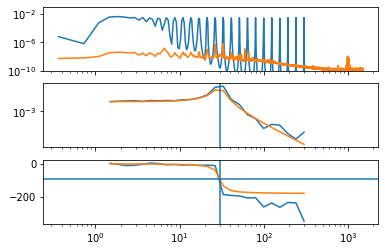

In [100]:
fig, ax = plt.subplots(3, 1, sharex=True)

i = 3

zeta = testzeta[i]
omegar = 2*np.pi * testfres[i]
omegas = 2*np.pi * f[i,:]

Htrue = 1.0 / (-omegas**2 - 2*(1j)*zeta*omegar*omegas + omegar**2)
Htrue = np.conj(Htrue)

ax[0].loglog(fall[1:], Pinwave[i,1:])
ax[0].loglog(fall[1:], Poutwave[i,1:])
ax[0].set_ylim([1e-10, 0.1])

Htrue *= np.abs(H[i,0]) / np.abs(Htrue[0])

ax[1].loglog(f[i,:], np.abs(H[i,:]))
ax[1].loglog(f[i,:], np.abs(Htrue))

ax[2].semilogx(f[i,:], np.rad2deg(np.unwrap(np.angle(H[i,:]))))
ax[2].semilogx(f[i,:], np.rad2deg(np.unwrap(np.angle(Htrue))))

ax[1].axvline(testfres[i])
ax[2].axvline(testfres[i])
ax[2].axhline(-90)

In [101]:
import pandas as pd

In [107]:
rawdata = pd.DataFrame()
for i, (fres1, zeta1, in1, out1) in enumerate(zip(testfres, testzeta, inwave, outwave)):
    data1 = pd.DataFrame({"in": in1, "out": out1})
    data1["fres"] = fres1
    data1["zeta"] = zeta1
    data1["trial"] = i
    
    rawdata = rawdata.append(data1)

In [109]:
rawdata

,in,out,fres,zeta,trial
0,1.148204,1.682604,4,1.2,0
1,1.147872,1.681947,4,1.2,0
2,1.147067,1.681947,4,1.2,0
3,1.145795,1.680632,4,1.2,0
4,1.144068,1.681782,4,1.2,0
...,...,...,...,...,...
299995,0.988797,1.565908,30,0.1,3
299996,1.054364,1.565250,30,0.1,3
299997,1.125826,1.565744,30,0.1,3
299998,1.179003,1.569195,30,0.1,3


In [110]:
freqdata = pd.DataFrame()
for i, (f1, fres1, zeta1, H1) in enumerate(zip(f, testfres, testzeta, H)):
    zeta = testzeta[i]

    omegar = 2*np.pi * fres1
    omegas = 2*np.pi * f1

    Htrue = 1.0 / (-omegas**2 - 2*(1j)*zeta*omegar*omegas + omegar**2)
    Htrue = np.conj(Htrue)
    
    data1 = pd.DataFrame({"f": f1, "H": H1, "Htrue": Htrue})
    data1["fres"] = fres1
    data1["zeta"] = zeta1
    data1["trial"] = i

    freqdata = freqdata.append(data1)

In [111]:
freqdata

,f,H,Htrue,fres,zeta,trial
0,0.200000,0.113955-0.013946j,1.564470e-03-1.882069e-04j,4,1.2,0
1,0.249406,0.113295-0.017144j,1.554246e-03-2.334903e-04j,4,1.2,0
2,0.311016,0.111712-0.020938j,1.538542e-03-2.888529e-04j,4,1.2,0
3,0.387845,0.110789-0.026156j,1.514586e-03-3.558002e-04j,4,1.2,0
4,0.483654,0.107999-0.032016j,1.478411e-03-4.353894e-04j,4,1.2,0
...,...,...,...,...,...,...
20,124.055566,-0.000132+0.000203j,-1.743548e-06-8.956523e-08j,30,0.1,3
21,154.700781,-0.000024+0.000219j,-1.097988e-06-4.424900e-08j,30,0.1,3
22,192.916225,-0.000052+0.000072j,-6.967762e-07-2.220789e-08j,30,0.1,3
23,240.571959,-0.000027+0.000042j,-4.443020e-07-1.125618e-08j,30,0.1,3


In [112]:
store = pd.HDFStore("test_force_feedback.h5")

In [113]:
store["rawdata"] = rawdata
store["freqdata"] = freqdata

In [114]:
store.close()